In [11]:
import sys
from pathlib import Path
sys.path.append(str(Path("..") / "src"))

import random
from pipeline import search
from evaluate_retriever import evaluate_retriever
from evaluate_reranker import evaluate_reranker
from metrics import recall_at_k, mrr, ndcg_at_k, hit_rate_at_k

import matplotlib.pyplot as plt
import pandas as pd

In [12]:
corpus = [{"doc_id": i, "text": f"Document {i}"} for i in range(50)]
queries = ["q1", "q2", "q3"]
relevant_docs = [{1}, {2, 5}, {10}]

In [13]:
class FakeRetriever:
    def __init__(self, corpus):
        self.corpus = corpus

    def search(self, query, top_k=10):
        return random.sample(self.corpus, top_k)

class FakeReranker:
    def score(self, query, passages):
        return [random.random() for _ in passages]

In [14]:
# 1 = использовать fake модели, 0 = реальные модели от роли A
USE_FAKE = 1

if USE_FAKE:
    retriever = FakeRetriever(corpus)
    reranker = FakeReranker()
else:
    retriever = retriever_model
    reranker = reranker_model

In [15]:
results = search(
    query="test query",
    retriever=retriever,
    reranker=reranker,
    top_k_retrieve=20,
    top_k_final=5
)

results


[{'doc_id': 16, 'text': 'Document 16'},
 {'doc_id': 26, 'text': 'Document 26'},
 {'doc_id': 1, 'text': 'Document 1'},
 {'doc_id': 19, 'text': 'Document 19'},
 {'doc_id': 36, 'text': 'Document 36'}]

In [16]:
retriever_metrics = evaluate_retriever(
    queries=queries,
    relevant_docs=relevant_docs,
    retriever=retriever
)

retriever_metrics

Evaluating Retriever: 100%|██████████| 3/3 [00:00<?, ?it/s]


{'Recall@5': 0.0,
 'HitRate@5': 0.0,
 'Recall@10': 0.3333333333333333,
 'HitRate@10': 0.3333333333333333,
 'Recall@20': 0.3333333333333333,
 'HitRate@20': 0.3333333333333333,
 'MRR': 0.047619047619047616,
 'nDCG@10': 0.11111111000000001}

In [17]:
reranker_metrics = evaluate_reranker(
    queries=queries,
    relevant_docs=relevant_docs,
    retriever=retriever,
    reranker=reranker,
    retrieve_k=20,
    final_k=5
)

reranker_metrics

Evaluating Reranker: 100%|██████████| 3/3 [00:00<?, ?it/s]


{'Recall@20': 0.3333333333333333,
 'HitRate@20': 0.3333333333333333,
 'MRR': 0.3333333333333333,
 'nDCG@10': 0.33333333000000004}

In [18]:
df = pd.DataFrame([retriever_metrics, reranker_metrics],
                  index=["Retriever", "Retriever + Reranker"])
df

,Recall@5,HitRate@5,Recall@10,HitRate@10,Recall@20,HitRate@20,MRR,nDCG@10
Retriever,0.0,0.0,0.333333,0.333333,0.333333,0.333333,0.047619,0.111111
Retriever + Reranker,NaN,NaN,NaN,NaN,0.333333,0.333333,0.333333,0.333333


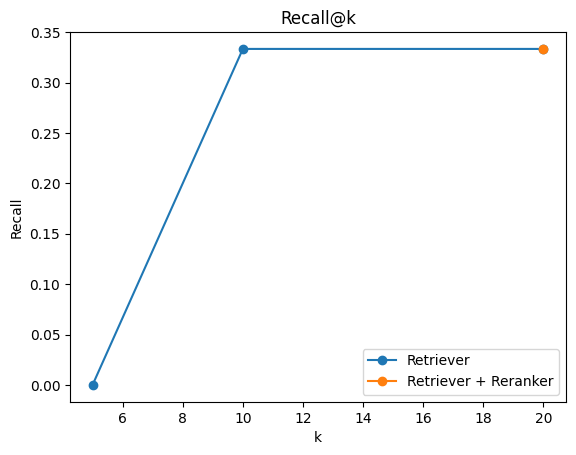

In [20]:
ks = [5, 10, 20]

retriever_recall = []
for k in ks:
    retriever_recall.append(retriever_metrics.get(f"Recall@{k}", None))

reranker_recall = []
for k in ks:
    reranker_recall.append(reranker_metrics.get(f"Recall@{k}", None))

plt.figure()
plt.plot(ks, retriever_recall, marker='o', label="Retriever")
plt.plot(
    [k for k, v in zip(ks, reranker_recall) if v is not None],
    [v for v in reranker_recall if v is not None],
    marker='o',
    label="Retriever + Reranker"
)
plt.xlabel("k")
plt.ylabel("Recall")
plt.title("Recall@k")
plt.legend()
plt.show()

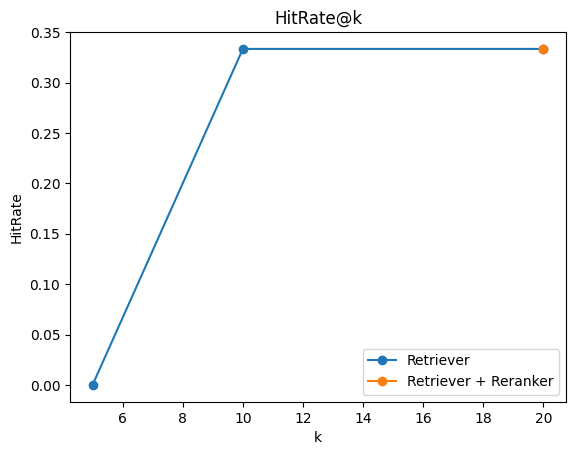

In [21]:
ks = [5, 10, 20]

# Retriever
retriever_hitrate = []
for k in ks:
    retriever_hitrate.append(retriever_metrics.get(f"HitRate@{k}", None))

# Reranker
reranker_hitrate = []
for k in ks:
    reranker_hitrate.append(reranker_metrics.get(f"HitRate@{k}", None))

plt.figure()
plt.plot(ks, retriever_hitrate, marker='o', label="Retriever")
plt.plot(
    [k for k, v in zip(ks, reranker_hitrate) if v is not None],
    [v for v in reranker_hitrate if v is not None],
    marker='o',
    label="Retriever + Reranker"
)
plt.xlabel("k")
plt.ylabel("HitRate")
plt.title("HitRate@k")
plt.legend()
plt.show()